# Chapter 3 Part 2:The shared corpus study
author: <span style="color:magenta">Poppy Riddle</span><br>
date: Mar 31, 2025
updated: July 31, 2025

## Data collection
- [ ] create sample collection from Crossref from part 1
- [ ] create shared corpus with works also found in OpenAlex matched on DOI
    - take DOI from Crossref sample df_collated2 export
    - send API call to OpenAlex for single work to select relevant elements or all and then refine down to elements needed for analysis
        - example API: https://api.openalex.org/works?filter=doi:10.7717/peerj.4375&select=doi,title,id,publication_year,language,abstract_inverted_index
    - reconstruct abstract from inverted 
        - [x] reconstruction code
- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
- [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc
    - [ ] visualize/diagram
- [ ] quantify differences
    - [ ] exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 
    - [ ] clean Crossref data for jats tags - what about MathML? Use regex pattern from Part 1<br>
        #clean abstract<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: x.replace('\n','').lstrip())<br>
        #the following is from: https://github.com/ourresearch/openalex-walden/blob/main/notebooks/ingest/PDF.py<br>
        title_abstract_df['abstract'] = title_abstract_df['abstract'].apply(lambda x: re.sub(r'<[^>]+>', '',x))<br>
    - [ ] Levenshtein ratio for str values that can accept some variation without changing meaning: https://rapidfuzz.github.io/Levenshtein/
        - title (may want to use Levenshtein.seqratio())
        - abstract (may want to use Levenshtein.seqratio())
- [ ] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type.
- [ ] identify which error types occur: incorrect values, missing info, inconsistent values
- [ ] visualize: other pubs have used Sankey diagram to show change - other ways to do this? Or improve upon the Sankey approach?

## helpers:
### Python
- the Pyalex library: https://pypi.org/project/pyalex/#get-abstract
- how to uninvert: https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index
- 


In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import requests
import pickle
import json
from colorama import Fore,Back,Style
import time
import csv
import xmltodict #probably not needed here
from tqdm import tqdm

In [2]:
# get samples from part 1
#file = "data/part_1_sample.txt"
#df = pd.read_csv(file, sep='\t', encoding='utf-8', header=0)
#print(df.columns) # look at column names
##df.drop(['Unnamed: 0','level_0'], axis=1, inplace=True)
#df.head(1) # just look at first one

# load pickled data 

with open('data/part_1_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
df = pd.DataFrame(data)
# unpack 'license' into 'license_version' and 'license_type'
df[['license_version', 'license_type']] = df['license'].apply(lambda x:pd.Series(x))
# handle empty values

# remove 'object' and 'license'
df.drop(columns=['object','license'], inplace=True)

# handle missing values
df.isnull().sum()
df.dtypes
df.replace({None:np.nan,'None':np.nan}, inplace=True)
df.info()
print(len(df))



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10100 entries, ('journal-article', np.int64(0)) to ('book-chapter', np.int64(299))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              10100 non-null  object
 1   type             10100 non-null  object
 2   title            10100 non-null  object
 3   abstract         10100 non-null  object
 4   language         4966 non-null   object
 5   cited_by         10100 non-null  int64 
 6   url              10100 non-null  object
 7   license_version  5909 non-null   object
 8   license_type     5909 non-null   object
dtypes: int64(1), object(8)
memory usage: 814.8+ KB
10100


In [3]:
# reconstruct abtract - from https://stackoverflow.com/questions/72093757/running-python-loop-to-iterate-and-undo-inverted-index


def reconstruct_abstract(abstract:dict)-> str:

    """
    This takes a dictionary of the inverted abstract
    and returns a string of the reconstructed abstract.

    Args:
    abstract should be in the form of a dictionary. 
    Example:
    abstract_inverted_index = {
    'Despite':[0],
    'growing':[1],
   'interest': [2],
    'in': [3],
    'Open': [4],
    'Access': [5],
    '...': [6]

    Returns:
    String 
    """

    # Create a list of (word, index) pairs
    word_index = []
    for k, v in abstract.items():
        for index in v:
            word_index.append([k, index])

    #print(word_index) # uncomment to see the sublists
    # Sort the list based on index
    word_index = sorted(word_index, key=lambda x: x[1]) # this sorts based on the second item in the sublist

    # Join the words with a space
    abstract = ' '.join([word for word, index in word_index])
    return abstract

In [4]:
# [x]: added requests.Session()<--
# get_openalex_data.py
import requests
import time
from functools import lru_cache

# Create a session object
session = requests.Session()

# send call to OpenAlex API
@lru_cache
def get_openalex_data(doi: str) -> dict:
    """
    Arg: takes a DOI as a string without the resolver.
    Return: A dictionary of values.

    Note: oa_abstract is reconstructed from the function reconstruct_abstract()
    """
    URL = f"https://api.openalex.org/works?filter=doi:{doi}&select=doi,title,id,type,type_crossref,language,abstract_inverted_index,cited_by_count,is_paratext,primary_location"

    try:
        result = session.get(URL)

        if result.status_code == 200:
            data = result.json()

            # Parse json data into each element:
            oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
            oa_title = data['results'][0]['title']
            oa_id = data['results'][0]['id']
            oa_type = data['results'][0]['type']
            oa_type_crossref = data['results'][0]['type_crossref']
            oa_language = data['results'][0]['language']
            oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
            oa_cited_by_count = data['results'][0]['cited_by_count']
            oa_is_paratext = data['results'][0]['is_paratext']
            oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
            oa_license = data['results'][0]['primary_location']['license']
            oa_version = data['results'][0]['primary_location']['version']

            # Reconstruct abstract
            oa_abstract = reconstruct_abstract(oa_abstract_inverted_index)

            return {
                'oa_doi': oa_doi,
                'oa_type': oa_type,
                'oa_type_crossref': oa_type_crossref,
                'oa_is_paratext': oa_is_paratext,
                'oa_title': oa_title,
                'oa_abstract': oa_abstract,
                'oa_language': oa_language,
                'oa_cited_by_count': oa_cited_by_count,
                'oa_primary_location_pdf_url': oa_primary_location_pdf_url,
                'oa_version': oa_version,
                'oa_license': oa_license,
                'oa_id': oa_id,
            }
        else:
            print(f"Error: Received status code {result.status_code} for DOI {doi}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Request failed for DOI {doi}: {e}")
        return None
    finally:
        # Sleep so that you are below the 10 per second limit or 100k per day.
        time.sleep(0.11)

# Example usage
# doi = "10.1234/example"
# data = get_openalex_data(doi)
# print(data)


In [5]:
#WARNING: This will take nearly 2 hours to run the full 10,100!
from tqdm import tqdm

openalex_data = []

#REMOVE FOR FULL RUN!
#df = df.head(100)

for doi in tqdm(df['DOI'],colour="MAGENTA"):
    try:
        result = get_openalex_data(doi)
        openalex_data.append(result)
    except AttributeError:
        result = f"{doi}"

df_openalex = pd.DataFrame(openalex_data)

print(Fore.MAGENTA + df_openalex.columns)


# save out the goods
folder_to_be_saved = 'Part_2_data'
if not os.path.exists(folder_to_be_saved):
    os.makedirs(folder_to_be_saved)
#export as .csv but tab separated
file_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.csv")

df_openalex.to_csv(file_to_be_saved, sep='\t', encoding='utf-8',na_rep='NA')

# also save out as pickle to preserve data types
pkl_to_be_saved = os.path.join(folder_to_be_saved, "part_2_OA_sample_collected.pkl")
df_openalex.to_pickle(pkl_to_be_saved)

df_openalex.head(2)

100%|██████████| 10100/10100 [59:47<00:00,  2.82it/s] 


Index(['oa_doi', 'oa_type', 'oa_type_crossref', 'oa_is_paratext', 'oa_title',
       'oa_abstract', 'oa_language', 'oa_cited_by_count', 'oa_primary_location_pdf_url',
       'oa_version', 'oa_license', 'oa_id'],
      dtype='object')


,oa_doi,oa_type,oa_type_crossref,oa_is_paratext,oa_title,oa_abstract,oa_language,oa_cited_by_count,oa_primary_location_pdf_url,oa_version,oa_license,oa_id
0,10.1521/soco.2021.39.5.543,article,journal-article,False,The Limits of Defaults: The Influence of Decis...,The stability of default effects to contextual...,en,4,None,None,None,https://openalex.org/W4206395497
1,10.1097/md.0000000000041851,article,journal-article,False,"Comparative analysis of demographic, clinical,...",The COVID-19 pandemic has brought a significan...,en,0,None,publishedVersion,cc-by-nc,https://openalex.org/W4408845899


# Analysis

- ✅ load and format data the same for easy comparison
- [ ] quantify differences
    - [ ] exact match for numerical or absolute str values
        - cited_by
        - language
        - URL
        - doc_type
        - license 
    - [ ] Levenshtein ratio for str values that can accept some variation without changing meaning: https://rapidfuzz.github.io/Levenshtein/
        - title (may want to use Levenshtein.seqratio())
        - abstract (may want to use Levenshtein.seqratio())

In [6]:
#make you a copy that does not have effects on the original
crossref_df = df.copy(deep=True)

#load you in the openalex data from the pickle
with open('Part_2_data/part_2_OA_sample_collected.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
openalex_df = pd.DataFrame(data)

In [7]:
print(Fore.LIGHTCYAN_EX + f"Crossref columns: \n{crossref_df.columns}")
print(Fore.LIGHTMAGENTA_EX + f"\n------\nOpenAlex columns: \n{openalex_df.columns}")

crossref_df.head(2).info()


Crossref columns: 
Index(['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type'], dtype='object')

------
OpenAlex columns: 
Index(['oa_doi', 'oa_type', 'oa_type_crossref', 'oa_is_paratext', 'oa_title', 'oa_abstract', 'oa_language',
       'oa_cited_by_count', 'oa_primary_location_pdf_url', 'oa_version', 'oa_license', 'oa_id'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2 entries, ('journal-article', np.int64(0)) to ('journal-article', np.int64(1))
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DOI              2 non-null      object
 1   type             2 non-null      object
 2   title            2 non-null      object
 3   abstract         2 non-null      object
 4   language         2 non-null      object
 5   cited_by         2 non-null      int64 
 6   url              2 non-null      object
 7   license_version  1 non-null  

In [10]:
openalex_df.head(2).info()
len(openalex_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   oa_doi                       2 non-null      object
 1   oa_type                      2 non-null      object
 2   oa_type_crossref             2 non-null      object
 3   oa_is_paratext               2 non-null      bool  
 4   oa_title                     2 non-null      object
 5   oa_abstract                  2 non-null      object
 6   oa_language                  2 non-null      object
 7   oa_cited_by_count            2 non-null      int64 
 8   oa_primary_location_pdf_url  0 non-null      object
 9   oa_version                   1 non-null      object
 10  oa_license                   1 non-null      object
 11  oa_id                        2 non-null      object
dtypes: bool(1), int64(1), object(10)
memory usage: 310.0+ bytes


9990

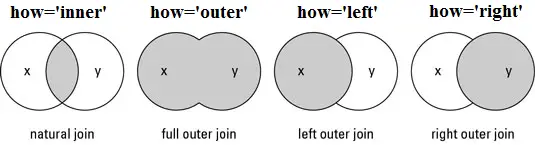<br>
source:https://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/

### overall changes
- [ ] identify changes from publisher deposited data (Crossref) to OpenAlex
    - DOI, title, abstract, license type, license, cited-by, language, and document type -> 0 for missing, 1 for present
    - create table


In [11]:
# Nan for crossref_df, None for openalex_df
overall_change = crossref_df.merge(openalex_df,left_on='DOI', right_on='oa_doi',how='outer')
overall_change = overall_change.replace({None:np.nan})
overall_change = overall_change.map(lambda x: 1 if pd.notna(x) else 0)

crossref_columns = ['DOI', 'type', 'title', 'abstract', 'language', 'cited_by', 'url', 'license_version', 'license_type']
openalex_columns = ['oa_doi', 'oa_type', 'oa_title', 'oa_abstract', 'oa_language', 'oa_cited_by_count', 'oa_primary_location_pdf_url', 'oa_version', 'oa_license']

crossref_overall_df = overall_change[crossref_columns]
openalex_overall_df = overall_change[openalex_columns]

crossref_overall_sums = pd.DataFrame(crossref_overall_df.sum())
openalex_overall_sums = pd.DataFrame(openalex_overall_df.sum())

crossref_overall_sums.reset_index(inplace=True)
crossref_overall_sums.rename(columns={'index': 'Element', 0: 'Crossref Sums'}, inplace=True)

openalex_overall_sums.reset_index(inplace=True)
openalex_overall_sums.rename(columns={'index':'OpenAlex', 0:'OA Sums'}, inplace=True)

overall_sums = pd.concat([crossref_overall_sums,openalex_overall_sums],axis=1 )
overall_sums = overall_sums.drop('OpenAlex', axis=1)

#save out
overall_sums.to_excel("Part_2_tables/overall_sums.xlsx")
overall_sums


,Element,Crossref Sums,OA Sums
0,DOI,10104,9994
1,type,10104,9994
2,title,10104,9991
3,abstract,10104,9994
4,language,4966,9971
5,cited_by,10104,9994
6,url,10104,5064
7,license_version,5911,6975
8,license_type,5911,4440


### DOI specific metadata
- [x] Matching DOIs between Crossref and OpenAlex
- [x] create table

In [12]:
# Compare Crossref df and oa df match on DOI
# new df with a boolean value if they share: doi, match_on_doi,...
# this will expand out for other boolean values

# match on df['doi'] and df_openalex['oa_doi']
match_on_doi_df = crossref_df[['DOI']].merge(openalex_df[['oa_doi']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_doi_df['match_on_doi'] = match_on_doi_df['DOI'] == match_on_doi_df['oa_doi']

match_on_doi_df = match_on_doi_df.drop(['oa_doi'], axis=1)

print(Fore.CYAN + f"percent matched from Crossref: {len(match_on_doi_df)/len(df)*100:.1f}%")
matched_on_doi_grouped = match_on_doi_df.groupby(['match_on_doi']).count()
print(Fore.LIGHTMAGENTA_EX + f"Matched on DOI: \n{matched_on_doi_grouped}")

matched_on_doi_grouped.to_excel("Part_2_tables/matched_on_doi_grouped.xlsx")


percent matched from Crossref: 100.0%
Matched on DOI: 
               DOI
match_on_doi      
False          110
True          9994


## URL
- [x] Change in DOI URL from Crossref to OpenAlex, (0,1)
- [x] count of those that have https vs http (as an indicator of link rot)
- [x] count of HTTP status code on all URLs
- [x] count of those not working (such as 400)

In [13]:
#url and oa_primary_location_pdf_url

match_on_url_df = crossref_df[['DOI','url']].merge(openalex_df[['oa_doi','oa_primary_location_pdf_url']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_url_df['match_on_url'] = match_on_url_df['url'] == match_on_url_df['oa_primary_location_pdf_url']

match_on_url_df = match_on_url_df.drop(['oa_doi'], axis=1)
match_on_url_df_grouped = match_on_url_df.groupby(match_on_url_df['match_on_url'])['DOI'].count()
print(Fore.LIGHTCYAN_EX + f"Matched on URL: \n{match_on_url_df_grouped}")

#save out
match_on_url_df_grouped.to_excel("Part_2_tables/match_on_url_df_grouped.xlsx")

#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_url_df.iloc[14,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_url_df.iloc[14,2]}")


# check for duplicate urls in either crossref or openalex - report this to Kyle
match_on_url_df['dupes'] = match_on_url_df['url'].duplicated()
duplicates = match_on_url_df[match_on_url_df['dupes']]
print(f"\n------\nThere are this many duplicates: {len(duplicates)}")
print(f"That is {len(duplicates)/len(match_on_url_df)*100}% of {len(match_on_url_df)}")

Matched on URL: 
match_on_url
False    10104
Name: DOI, dtype: int64
Crossref version: https://onlinelibrary.wiley.com/doi/10.1002/acs.3099
OpenAlex version: None

------
There are this many duplicates: 7
That is 0.06927949326999208% of 10104


In [14]:
# num with http vs https in url and in oa_primary_location_pdf_url
# clean up None in the openalex urls
match_on_url_df = match_on_url_df.replace({None:'None'})

#count 1 if there is http, otherwise 0 for https
match_on_url_df['cr_http_count'] = match_on_url_df['url'].apply(lambda x: 1 if x.startswith('http://') else 0)
match_on_url_df['oa_http_count'] = match_on_url_df['oa_primary_location_pdf_url'].apply(lambda x: 1 if x.startswith('http://') else 0)

match_on_url_http_count = match_on_url_df[['cr_http_count','oa_http_count']]
match_on_url_http_count = pd.DataFrame(match_on_url_http_count.sum(),columns=['Counts'])
match_on_url_http_count.to_excel("Part_2_tables/match_on_url_http_count.xlsx")
match_on_url_http_count


,Counts
cr_http_count,968
oa_http_count,380


In [15]:
# http status codes
# Previously I did the Crossref ones. they are stored in a pickle here:
# and load pickle if you need
with open('data/df_data_url.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)

# create dataframe
crossref_data_url = pd.DataFrame(data)
len(crossref_data_url)
crossref_data_url.reset_index(inplace=True)
crossref_data_url.drop(columns=['level_0','level_1'], inplace=True)
crossref_data_url

,DOI,url,type,status_code
0,10.1521/soco.2021.39.5.543,https://guilfordjournals.com/doi/10.1521/soco....,journal-article:None,403
1,10.1097/md.0000000000041851,https://journals.lww.com/10.1097/MD.0000000000...,journal-article:None,403
2,10.32996/jmcie.2021.2.2.10,https://www.al-kindipublisher.com/index.php/jm...,journal-article:None,200
3,10.12957/cdf.2025.89476,https://www.e-publicacoes.uerj.br/cdf/article/...,journal-article:None,200
4,10.51845/36.4.15,https://www.nas.org/academic-questions/36/4/ge...,journal-article:None,200
...,...,...,...,...
10095,10.1093/hesc/9780198866657.003.0038,https://www.oxfordsciencetrove.com/view/10.109...,book-chapter:None,403
10096,10.3735/9781935306627.book-part-182,https://library.schlagergroup.com/chapter/9781...,book-chapter:None,200
10097,10.1093/oso/9780197619995.003.0005,https://academic.oup.com/book/38898/chapter/33...,book-chapter:None,403
10098,10.1007/978-3-658-42221-9_10,https://link.springer.com/10.1007/978-3-658-42...,book-chapter:None,200


In [16]:
from check_status_code import check_status_code,check_urls


In [17]:
from check_status_code import check_status_code,check_urls

tqdm.pandas(colour='cyan')

#covert the column 'oa_primary_location_pdf_url' to a list
urls = openalex_df['oa_primary_location_pdf_url'].tolist()

#check status codes with multithreading function - takes a list
print(Fore.LIGHTMAGENTA_EX + f"hang on...this can take a while for the length of this list: {len(urls)} list...\n")
status_codes = tqdm(check_urls(urls),colour='cyan')

openalex_data_url = openalex_df[['oa_doi', 'oa_primary_location_pdf_url', ]].copy()
openalex_data_url['openalex_status_code'] = status_codes


#openalex_data_url = openalex_df[['oa_doi','oa_primary_location_pdf_url']]
#openalex_data_url['openalex_status_code'] = openalex_data_url['oa_primary_location_pdf_url'].progress_apply(lambda x: check_status_code(x) if pd.notna(x) else "Access Failed")

# save out the openalex_data_url to a pickle for loading later
openalex_data_url.to_pickle('Part_2_data/openalex_data_url.pkl')



hang on...this can take a while for the length of this list: 9990 list...



100%|██████████| 9990/9990 [00:00<00:00, 2659711.63it/s]


In [18]:
print(openalex_data_url.iloc[15,1])
openalex_data_url

None


,oa_doi,oa_primary_location_pdf_url,openalex_status_code
0,10.1521/soco.2021.39.5.543,None,Attempt failed
1,10.1097/md.0000000000041851,None,Attempt failed
2,10.32996/jmcie.2021.2.2.10,None,Attempt failed
3,10.12957/cdf.2025.89476,None,Attempt failed
4,10.51845/36.4.15,None,Attempt failed
...,...,...,...
9985,10.7591/cornell/9781501766985.003.0002,None,Attempt failed
9986,10.1093/hesc/9780198866657.003.0038,None,200
9987,10.3735/9781935306627.book-part-182,None,200
9988,10.1093/oso/9780197619995.003.0005,None,200


In [23]:
# load saaved openalex_data_url from pickle
with open('Part_2_data/openalex_data_url.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not have to specify it.
    data = pickle.load(f)
openalex_data_url = pd.DataFrame(data)

# need to combine this with the imported ones from crossref url to match on DOI
openalex_data_url = openalex_data_url.merge(crossref_data_url, left_on='oa_doi', right_on='DOI', how='inner')

openalex_data_url = openalex_data_url[['oa_doi', 'openalex_status_code','status_code']]

openalex_data_url = openalex_data_url.rename(columns={'status_code':'crossref_status_code'})
openalex_data_url


openalex_count = pd.DataFrame(openalex_data_url.groupby(openalex_data_url['openalex_status_code'])['oa_doi'].count())
crossref_count = pd.DataFrame(openalex_data_url.groupby(openalex_data_url['crossref_status_code'])['oa_doi'].count())

openalex_count = openalex_count.rename_axis('Status code').rename(columns={'oa_doi':'openalex count'})
crossref_count = crossref_count.rename_axis('Status code').rename(columns={'oa_doi':'crossref count'})

total_counts = pd.concat([openalex_count, crossref_count], axis=1)
total_counts = total_counts.sort_index(ascending=True)
#save out
total_counts.to_excel("Part_2_tables/total_counts.xlsx")

total_counts


,openalex count,crossref count
Status code,,
200,3198.0,6232.0
202,14.0,NaN
400,2.0,4.0
401,NaN,1.0
403,1478.0,2879.0
404,104.0,74.0
405,1.0,5.0
406,NaN,82.0
409,2.0,NaN


### publication type
- [ ] count of each type
- [ ] change from Crossref to Openalex, 0,1?
- [ ] % distribution 
- [ ] maybe a good place for a sankey diagram showing changes

In [28]:
# compare exact match for values -> bool
# check for type - make this into a sankey diagram
# match on crossref_df[['DOI',type]] and openalex_df[['oa_doi','oa_type', 'oa_type_crossref']]
match_on_type_df = crossref_df[['DOI','type']].merge(openalex_df[['oa_doi','oa_type', 'oa_type_crossref']], left_on='DOI', right_on='oa_doi', how='outer')

#refine type from crossref to rstrip ':None'
match_on_type_df['type'] = match_on_type_df['type'].apply(lambda x: x.replace(':None',''))
match_on_type_df['match_on_type'] = match_on_type_df['type'] == match_on_type_df['oa_type_crossref']

match_on_type_df = match_on_type_df.drop(['oa_doi'], axis=1)
match_on_type_df_grouped = match_on_type_df.groupby(match_on_type_df['match_on_type'])['DOI'].count()
print(Fore.GREEN + f"Matched on type: \n{match_on_type_df_grouped}")

# save out
match_on_type_df_grouped.to_excel("Part_2_tables/match_on_type_df_grouped.xlsx")
match_on_type_df

Matched on type: 
match_on_type
False     117
True     9987
Name: DOI, dtype: int64


,DOI,type,oa_type,oa_type_crossref,match_on_type
0,10.1001/jamainternmed.2023.1832,journal-article,article,journal-article,True
1,10.1001/jamanetworkopen.2022.43134,journal-article,article,journal-article,True
2,10.1001/jamanetworkopen.2023.54249,journal-article,review,journal-article,True
3,10.1001/jamanetworkopen.2024.48208,journal-article,article,journal-article,True
4,10.1001/jamaophthalmol.2023.0610,journal-article,article,journal-article,True
...,...,...,...,...,...
10099,10.9785/gvrz-2024-070205,journal-article,article,journal-article,True
10100,10.9785/rra-2024-320204,journal-article,article,journal-article,True
10101,10.9788/cp2023.2-08,journal-article,article,journal-article,True
10102,10.9790/487x-2612082934,journal-article,article,journal-article,True


In [32]:
type_false_grouped = match_on_type_df[match_on_type_df['match_on_type']==False]
print(f"length of type_false_grouped: \n{len(type_false_grouped)}")
type_false_grouped = type_false_grouped.groupby(['type']).count()
type_false_grouped

length of type_false_grouped: 
117


,DOI,oa_type,oa_type_crossref,match_on_type
type,,,,
book-chapter,16,0,0,16
journal-article,101,7,7,101


### title
- [x] change between Crossref and OpenAlex 0,1?
<br>If False, then<br>
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

In [61]:
# re.sub('\s{2,}', ' ', text)
import re
# match on title
match_on_title_df = crossref_df[['DOI', 'title']].merge(openalex_df[['oa_doi','oa_title']], left_on='DOI', right_on='oa_doi', how='outer')

# text cleaning for extra spaces
match_on_title_df[['title','oa_title']] = match_on_title_df[['title', 'oa_title']].map(lambda x: re.sub(r'\s{2,}', ' ', str(x)))

# If you want to strip leading and trailing spaces as well
match_on_title_df = match_on_title_df.map(lambda x: x.strip() if pd.notna(x) else x)

# remove non-break characters and others from Latin-1 supplement or General Punc
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u00A0', '\u0020'))
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u000D', '\u0020'))
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace('\u2010', '\u0020'))

# remove <i> formatting
match_on_title_df[['title','oa_title']] = match_on_title_df[['title','oa_title']].map(lambda x: x.replace(r'<i>', '').replace(r'</i>',''))

match_on_title_df['match_on_title'] = match_on_title_df['title'] == match_on_title_df['oa_title']
match_on_title_df = match_on_title_df.drop(['oa_doi'], axis=1)
match_on_title_df_grouped = match_on_title_df.groupby(match_on_title_df['match_on_title'])['DOI'].count()
print(match_on_title_df_grouped)

#save out
match_on_title_df_grouped.to_excel("Part_2_tables/match_on_title_df_grouped.xlsx")

# let's manualy check those false values..
false_values = match_on_title_df[match_on_title_df['match_on_title']==False].index
print(Fore.LIGHTYELLOW_EX + f"\n----\nfalse value index: {false_values[1]}")
print(match_on_title_df.iloc[false_values[1],1:3])
#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[false_values[1],1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[false_values[1],2]}")




match_on_title
False     323
True     9781
Name: DOI, dtype: int64

----
false value index: 115
title       Silylation of Aryl and Alkyl Chlorides by a Se...
oa_title    Silylation of Aryl and Alkyl Chlorides by a Se...
Name: 115, dtype: object
Crossref version: Silylation of Aryl and Alkyl Chlorides by a Seven Membered Dialkoxysilyl Group Si(pan)Me via an In Situ Generated Silylpotassium
OpenAlex version: Silylation of Aryl and Alkyl Chlorides by a Seven Membered Dialkoxysilyl Group Si(pan)Me via an in situ Generated Silylpotassium


In [88]:
# all False in a separate df and analyse manually
false_match_on_title = match_on_title_df[match_on_title_df['match_on_title']==False]
# then add these back into match_on_title_df to replace values in 'match_on_title'
match_on_title_df.columns
# export in excel and manually work on them

false_match_on_title.to_excel("Part_2_data/false_match_on_title.xlsx")
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[116,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_title_df.iloc[116,2]}")



Crossref version: Engineering Bodipy Based Metal–Organic Frameworks for Efficient Full Spectrum Photocatalysis in Amide Synthesis
OpenAlex version: Engineering Bodipy Based Metal−Organic Frameworks for Effi cient Full Spectrum Photocatalysis in Amide Synthesis


### abstract
- [x] change between Crossref and OpenAlex?
If failed then...
- [ ] count of tokens in each
- [ ] count of stopwords
- [ ] count of punctuation
- [ ] count of special char, formating char
- [ ] count of numerals
- [ ] count of tags or other non-text elements
- [ ] visualize distribution of these across both databases

In [89]:
# match on abstract - use same process as title?
# re.sub('\s{2,}', ' ', text)

import unicodedata

def remove_general_punc(s: str) -> str:
    """
    Removes characters from the Unicode General Punctuation block.
    Purpose: remove thin space characters from text by specifying codepoints
    """
    general_punctuation = set()
    for i in range(0x2000, 0x2070):
        general_punctuation.add(chr(i))

    return ''.join([char for char in s if char not in general_punctuation])

# match on abstract
match_on_abstract_df = crossref_df[['DOI', 'abstract']].merge(openalex_df[['oa_doi','oa_abstract']], left_on='DOI', right_on='oa_doi', how='outer')

# text cleaning for all JATS tags
#source: https://github.com/ourresearch/openalex-walden/blob/main/libraries/dlt_utils/openalex/dlt/transform.py
match_on_abstract_df[['abstract','oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: re.sub(r"\n|\t|<jats:[^>]*?>|</jats:[^>]*?>|<p>|</p>", ' ', str(x)))
# text cleaning for extra spaces
match_on_abstract_df[['abstract','oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: re.sub(r'\s{2,}', ' ', str(x)))
# if you want to strip leading and trailing spaces as well
match_on_abstract_df = match_on_abstract_df.map(lambda x: x.strip() if pd.notna(x) else x)
# remove all thin space
match_on_abstract_df[['abstract', 'oa_abstract']] = match_on_abstract_df[['abstract', 'oa_abstract']].map(lambda x: remove_general_punc(x))

match_on_abstract_df['match_on_abstract'] = match_on_abstract_df['abstract'] == match_on_abstract_df['oa_abstract']
match_on_abstract_df = match_on_abstract_df.drop(['oa_doi'], axis=1)
match_on_abstract_df_grouped = match_on_abstract_df.groupby(match_on_abstract_df['match_on_abstract'])['DOI'].count()
print(match_on_abstract_df_grouped)

# save out
match_on_abstract_df_grouped.to_excel("Part_2_tables/match_on_abstract_df_grouped.xlsx")

# num_match
num_match = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==True]["DOI"].count()
print(Fore.LIGHTYELLOW_EX + f"number of those that match: {num_match} out of {len(match_on_abstract_df)}")


match_on_abstract
False    2131
True     7973
Name: DOI, dtype: int64
number of those that match: 7973 out of 10104


In [92]:
#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[0,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[0,2]}")

#individually correct the false positives
# let's manualy check those false values..
false_values = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==False].index
print(Fore.LIGHTYELLOW_EX + f"\n----\nfalse value index: {false_values[0]} out of {len(false_values)}")

#create a new df with just those with False values
false_match_on_abstract = match_on_abstract_df[match_on_abstract_df['match_on_abstract']==False]

#save out for manual check
false_match_on_abstract.to_excel("Part_2_data/false_match_on_abstract.xlsx")

#examine the false ones
print(Fore.LIGHTCYAN_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[false_values[0],1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_abstract_df.iloc[false_values[0],2]}")

Crossref version: This Perspective envisions a world where artificial intelligence is integrated into health care.
OpenAlex version: This Perspective envisions a world where artificial intelligence is integrated into health care.

----
false value index: 1 out of 2131
Crossref version: Importance Prior studies have revealed gender differences in the milestone and clinical competency committee assessment of emergency medicine (EM) residents. Objective To explore gender disparities and the reasons for such disparities in the narrative comments from EM attending physicians to EM residents. Design, Setting, and Participants This multicenter qualitative analysis examined 10488 narrative comments among EM faculty and EM residents between 2015 to 2018 in 5 EM training programs in the US. Data were analyzed from 2019 to 2021. Main Outcomes and Measures Differences in narrative comments by gender and study site. Qualitative analysis included deidentification and iterative coding of the data set

## cited by count
- [ ] std dev of differences between two samples
- [ ] n with change
- [ ] % affected
- [ ] visualize to see if one database favors more than the other

In [94]:
# cited_by and oa_cited_by_count 

match_on_cited_df = crossref_df[['DOI','cited_by']].merge(openalex_df[['oa_doi','oa_cited_by_count']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_cited_df['match_on_cited'] = match_on_cited_df['cited_by'] == match_on_cited_df['oa_cited_by_count']

match_on_cited_df = match_on_cited_df.drop(['oa_doi'], axis=1)
match_on_cited_df_grouped = match_on_cited_df.groupby(match_on_cited_df['match_on_cited'])['DOI'].count()
print(Fore.LIGHTMAGENTA_EX + f"Matched on cited_by: \n{match_on_cited_df_grouped}")

# save out
match_on_cited_df_grouped.to_excel("Part_2_tables/match_on_cited_df_grouped.xlsx")

Matched on cited_by: 
match_on_cited
False    4221
True     5883
Name: DOI, dtype: int64


### license
- [x] change between Crossref and OpenAlex?
- [ ] count of types for each
- [ ] count of those with licenses vs without
- [ ] % of those with 
- [ ] count of common or proprietary licenses
- [ ] visualization of distribution of license types

In [110]:
#license_type and oa_license

match_on_license_type_df = crossref_df[['DOI','license_type']].merge(openalex_df[['oa_doi','oa_license']], left_on='DOI', right_on='oa_doi', how='outer')

#cleaning: crossref - replace  http://creativecommons.org/licenses/ and  https://creativecommons.org/licenses/ with 'cc-'
# remove trailing /
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('http://creativecommons.org/licenses/', 'cc-')
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].str.replace('https://creativecommons.org/licenses/', 'cc-')
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].apply(lambda x: re.sub(r'/.*','',str(x)) if pd.notna(x) else x)
match_on_license_type_df['license_type'] = match_on_license_type_df['license_type'].fillna(value='None')
match_on_license_type_df['oa_license'] = match_on_license_type_df['oa_license'].apply(lambda x: str(x))


match_on_license_type_df['match_on_license_type'] = match_on_license_type_df['license_type'] == match_on_license_type_df['oa_license']

match_on_license_type_df = match_on_license_type_df.drop(['oa_doi'], axis=1)
match_on_license_type_df_grouped = match_on_license_type_df.groupby(match_on_license_type_df['match_on_license_type'])['DOI'].count()
print(Fore.LIGHTCYAN_EX + f"Matched on license type: \n{match_on_license_type_df_grouped}")
#save out
match_on_license_type_df_grouped.to_excel("Part_2_tables/match_on_license_type_df_grouped.xlsx")

#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_license_type_df.iloc[19,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_license_type_df.iloc[19,2]}")

# for manual inspection of false ones
match_on_license_type_df.columns
false_match_on_license_type = match_on_license_type_df[match_on_license_type_df['match_on_license_type']==False]
false_match_on_license_type



Matched on license type: 
match_on_license_type
False    3540
True     6564
Name: DOI, dtype: int64
Crossref version: cc-by
OpenAlex version: cc-by


,DOI,license_type,oa_license,match_on_license_type
1,10.1001/jamanetworkopen.2022.43134,None,cc-by-nc-nd,False
2,10.1001/jamanetworkopen.2023.54249,None,cc-by-nc-nd,False
3,10.1001/jamanetworkopen.2024.48208,None,cc-by-nc-nd,False
6,10.1001/jamasurg.2022.8419,None,cc-by,False
9,10.1002/2211-5463.13176,cc-by,None,False
...,...,...,...,...
10094,10.9744/nirmana.23.1.50-58,None,cc-by,False
10095,10.9755/ejfa.2021.v33.i4.2685,cc-by-nc,cc-by,False
10096,10.9771/cp.v14i3.29695,None,cc-by,False
10097,10.9771/rbda.v19i0.63435,cc-by-nc,None,False


In [ ]:
# do a groupby on 'license_type' then by 'oa_license' to see how many counts of these line up
#which are most frequently not aligned?


### Crossref's vor
Crossref's 'vor' license version is equivalent to the published version. <br>
See reference here: https://www.crossref.org/documentation/principles-practices/best-practices/versioning/

In [43]:
# license version check

match_on_license_version_df = crossref_df[['DOI','license_version']].merge(openalex_df[['oa_doi','oa_version']], left_on='DOI', right_on='oa_doi', how='outer')

# change vor to published version

match_on_license_version_df['license_version'] = match_on_license_version_df['license_version'].apply(lambda x: 'publishedVersion' if x=='vor' else x)

match_on_license_version_df['match_on_license_version'] = match_on_license_version_df['license_version'] == match_on_license_version_df['oa_version']

match_on_license_version_df = match_on_license_version_df.drop(['oa_doi'], axis=1)
match_on_license_version_df_grouped = match_on_license_version_df.groupby(match_on_license_version_df['match_on_license_version'])['DOI'].count()
print(Fore.LIGHTMAGENTA_EX + f"Matched on license version: \n{match_on_license_version_df_grouped}")

#save out
match_on_license_version_df_grouped.to_excel("Part_2_tables/match_on_license_version_df_grouped.xlsx")
#examine the false ones
print(Fore.LIGHTYELLOW_EX + f"Crossref version: "+Style.RESET_ALL+f"{match_on_license_version_df.iloc[19,1]}")
print(Fore.LIGHTMAGENTA_EX + f"OpenAlex version: "+Style.RESET_ALL+f"{match_on_license_version_df.iloc[19,2]}")

match_on_license_version_df

Matched on license version: 
match_on_license_version
False    65
True     35
Name: DOI, dtype: int64
Crossref version: publishedVersion
OpenAlex version: publishedVersion


,DOI,license_version,oa_version,match_on_license_version
0,10.1002/adfm.202307501,publishedVersion,None,False
1,10.1002/adma.202310083,publishedVersion,None,False
2,10.1002/anie.202111206,publishedVersion,None,False
3,10.1002/jocb.1534,publishedVersion,publishedVersion,True
4,10.1002/lno.12531,publishedVersion,publishedVersion,True
...,...,...,...,...
95,10.55529/jpdmhd.46.33.45,NaN,publishedVersion,False
96,10.56437/jikp.v6i2.68,NaN,publishedVersion,False
97,10.62810/jss.v6i3.106,unspecified,None,False
98,10.62951/modem.v2i4.236,unspecified,None,False


### languages
- [ ] change between Crossref and OpenAlex
- [ ] count of types
- [ ] % declared in abstract
    - found in XML API
- [ ] % declared in journal title level
    - found in REST API
- [ ] visualization of distribution of language types

In [45]:
#language

# match on crossref_df[['DOI',type]] and openalex_df[['oa_doi','oa_type', 'oa_type_crossref']]
match_on_lang_df = crossref_df[['DOI','language']].merge(openalex_df[['oa_doi','oa_language']], left_on='DOI', right_on='oa_doi', how='outer')

match_on_lang_df['match_on_lang'] = match_on_lang_df['language'] == match_on_lang_df['oa_language']

match_on_lang_df = match_on_lang_df.drop(['oa_doi'], axis=1)
match_on_lang_df_grouped = match_on_lang_df.groupby(match_on_lang_df['match_on_lang'])['DOI'].count()
print(Fore.LIGHTCYAN_EX + f"Matched on Language: \n{match_on_lang_df_grouped}")

match_on_lang_df_grouped.to_excel("Part_2_tables/match_on_lang_df_grouped.xlsx")
match_on_lang_df

Matched on Language: 
match_on_lang
False    44
True     56
Name: DOI, dtype: int64


,DOI,language,oa_language,match_on_lang
0,10.1002/adfm.202307501,en,en,True
1,10.1002/adma.202310083,en,en,True
2,10.1002/anie.202111206,en,en,True
3,10.1002/jocb.1534,en,en,True
4,10.1002/lno.12531,en,en,True
...,...,...,...,...
95,10.55529/jpdmhd.46.33.45,en,en,True
96,10.56437/jikp.v6i2.68,NaN,id,False
97,10.62810/jss.v6i3.106,NaN,fa,False
98,10.62951/modem.v2i4.236,NaN,en,False


## Subset Analysis

### License
IF there are differences, an examination of changes between two sources. This may require a subset based on filtering from above. 
- [ ] comparison of license in each source
- [ ] apply an error classification: incorrect, missing, inconsistent

### title and abstract
- [ ] filter df from above for those with differences 
    - [ ] use subset if needed due to quantity
- [ ] compare title from each source based on Levenshtein seqratio
- [ ] compare abstract from each source based on Levenshtein seqratio
- [ ] apply classification
- [ ] identify error types 


In [93]:
#  import false_match_on_title.xlsx after manual review and add to match_on_title_df to get a better count

# new match_on_title_count
false_match_on_abstract



,DOI,abstract,oa_abstract,match_on_abstract
1,10.1001/jamanetworkopen.2022.43134,Importance Prior studies have revealed gender ...,Importance Prior studies have revealed gender ...,False
2,10.1001/jamanetworkopen.2023.54249,Importance Although multiple mechanisms have b...,Although multiple mechanisms have been propose...,False
3,10.1001/jamanetworkopen.2024.48208,Importance Fragility fractures are often defin...,Importance Fragility fractures are often defin...,False
4,10.1001/jamaophthalmol.2023.0610,Importance New-onset retinal vascular occlusio...,New-onset retinal vascular occlusion (RVO) occ...,False
6,10.1001/jamasurg.2022.8419,Importance Cancer transmission is a known risk...,Cancer transmission is a known risk for recipi...,False
...,...,...,...,...
10045,10.7717/peerj.16226,Background Influenza is an acute infectious re...,Influenza is an acute infectious respiratory d...,False
10046,10.7717/peerj.18079,Background Work-related musculoskeletal disord...,Work-related musculoskeletal disorders (WRMDs)...,False
10047,10.7717/peerj.18961,The globe cultivation and industrial productio...,The globe cultivation and industrial productio...,False
10054,10.7827/turkishstudies.44390,"In this study, it was aimed to investigate the...","In this study, it was aimed to investigate the...",False


In [35]:
#for abstract
# import "false_match_on_abstract.xlsx" after manual check and recount match_on_abstract_df

# or do levenshtein distance on abstract (tricky given the lengths)

# diagram of crosswalk between Crossref and OpenAlex

- [ ] Crossref schema and OpenAlex schema comparison
    - Crossref schema: https://data.crossref.org/reports/help/schema_doc/5.3.1/index.html
    - OpenAlex schema: https://docs.openalex.org/api-entities/works/work-object
    - create diagram of this map
    - create dictionary to build later
    - [ ] create mapping of metadata element from Crossref and its respective element in OpenAlex
    - cr_title -> openalex_title
    - cr_citedby_count -> openalex_citedby
    - etc

In [ ]:
#parse json data into each element:
data = data #returned from OpenAlex REST API
oa_doi = data['results'][0]['doi'].lstrip('https://doi.org/')
oa_title = data['results'][0]['title']
oa_id = data['results'][0]['id']
oa_type = data['results'][0]['type']
oa_type_crossref = data['results'][0]['type_crossref']
oa_language = data['results'][0]['language']
oa_abstract_inverted_index = data['results'][0]['abstract_inverted_index']
oa_cited_by_count = data['results'][0]['cited_by_count']
oa_is_paratext = data['results'][0]['is_paratext']
oa_primary_location_pdf_url = data['results'][0]['primary_location']['pdf_url']
oa_license = data['results'][0]['primary_location']['license']
oa_version = data['results'][0]['primary_location']['version']